In [2]:
!pip install torch

   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.7 MB 1.9 MB/s eta 0:01:24
   ---------------------------------------- 0.1/159.7 MB 1.3 MB/s eta 0:02:01
   ---------------------------------------- 0.1/159.7 MB 1.3 MB/s eta 0:02:02
   ---------------------------------------- 0.2/159.7 MB 1.3 MB/s eta 0:02:03
   ---------------------------------------- 0.2/159.7 MB 1.2 MB/s eta 0:02:13
   ---------------------------------------- 0.3/159.7 MB 1.4 MB/s eta 0:01:54
   ---------------------------------------- 0.4/159.7 MB 1.5 MB/s eta 0:01:46
   ---------------------------------------- 0.4/159.7 MB 1.5 MB/s eta 0:01:46
   ---------------------------------------- 0.7/159.7 MB 1.7 MB/s eta 0:01:32
   ---------------------------------------- 0.7/159.7 MB 1.7 MB/s eta 0:01:32
   ---------------------------------------- 0.8/159.7 MB 1.8 MB/s eta 0:01:29
   ---------------------------------------- 1.1/159.7 MB 2.1 MB/s eta 0

In [6]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:


class MovieLensDataset(Dataset):
    def __init__(self, ratings, all_movie_ids, all_user_ids):
        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(all_user_ids)}
        self.movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(all_movie_ids)}
        
        self.users = torch.tensor([self.user_to_idx[user_id] for user_id in ratings['userId'].values], dtype=torch.long)
        self.movies = torch.tensor([self.movie_to_idx[movie_id] for movie_id in ratings['movieId'].values], dtype=torch.long)
        self.ratings = torch.tensor((ratings['rating'].values - 0.5) / 4.5, dtype=torch.float32)  # 缩放到 [0, 1]

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

def load_data():
    ratings = pd.read_csv('ml-latest-small/ratings.csv')
    movies = pd.read_csv('ml-latest-small/movies.csv')
    users = pd.read_csv('ml-latest-small/ratings.csv')['userId'].unique()
    
    train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
    all_movie_ids = movies['movieId'].unique()
    all_user_ids = users
    
    train_dataset = MovieLensDataset(train_ratings, all_movie_ids, all_user_ids)
    test_dataset = MovieLensDataset(test_ratings, all_movie_ids, all_user_ids)
    
    return train_dataset, test_dataset, len(all_user_ids), len(all_movie_ids), test_ratings

train_dataset, test_dataset, num_users, num_items, test_ratings = load_data()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [8]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_users, latent_dim)
        self.item_emb = nn.Embedding(num_items, latent_dim)
        self.output = nn.Linear(latent_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_emb(user_indices)
        item_embedding = self.item_emb(item_indices)
        interaction = user_embedding * item_embedding
        logits = self.output(interaction)
        return self.sigmoid(logits).view(-1, 1)  # 保持输出为 (batch_size, 1)

class MLP(nn.Module):
    def __init__(self, num_users, num_items, layers):
        super(MLP, self).__init__()
        self.user_emb = nn.Embedding(num_users, layers[0] // 2)
        self.item_emb = nn.Embedding(num_items, layers[0] // 2)
        self.fc_layers = nn.Sequential(
            *[nn.Sequential(nn.Linear(layers[i], layers[i+1]), nn.ReLU())
              for i in range(len(layers)-1)]
        )
        self.output = nn.Linear(layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_emb(user_indices)
        item_embedding = self.item_emb(item_indices)
        x = torch.cat([user_embedding, item_embedding], dim=-1)
        x = self.fc_layers(x)
        logits = self.output(x)
        return self.sigmoid(logits).view(-1, 1)  # 保持输出为 (batch_size, 1)

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, gmf_dim, mlp_layers):
        super(NeuMF, self).__init__()
        self.gmf = GMF(num_users, num_items, gmf_dim)
        self.mlp = MLP(num_users, num_items, mlp_layers)
        self.output = nn.Linear(2, 1)  # GMF 和 MLP 合并后为 2 个特征
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        gmf_output = self.gmf(user_indices, item_indices)
        mlp_output = self.mlp(user_indices, item_indices)
        x = torch.cat([gmf_output, mlp_output], dim=1)  # 确保正确合并两个模型的输出
        logits = self.output(x)
        return self.sigmoid(logits)



In [12]:

def train_model(model, train_loader, epochs, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    
    model.train()
    for epoch in range(epochs):
        for users, items, ratings in train_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            optimizer.zero_grad()
            outputs = model(users, items).squeeze()
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}: Loss = {loss.item()}')

# 初始化GMF模型
gmf_model = GMF(num_users, num_items, latent_dim=10)
# 训练GMF模型
train_model(gmf_model, train_loader, epochs=200, lr=0.01)

# 初始化MLP模型，假设有两层，每层10个神经元
mlp_model = MLP(num_users, num_items, [20, 10])  # 层数和每层的大小可以根据需要进行调整
# 训练MLP模型
train_model(mlp_model, train_loader, epochs=200, lr=0.01)

# 初始化并训练NeuMF模型
neumf_model = NeuMF(num_users, num_items, gmf_dim=10, mlp_layers=[20, 10])
train_model(neumf_model, train_loader, epochs=200, lr=0.01)



Epoch 1: Loss = 0.6341724991798401
Epoch 2: Loss = 0.6444497108459473
Epoch 3: Loss = 0.6666793823242188
Epoch 4: Loss = 0.5897279977798462
Epoch 5: Loss = 0.6688751578330994
Epoch 6: Loss = 0.5999568104743958
Epoch 7: Loss = 0.6477134823799133
Epoch 8: Loss = 0.6649538278579712
Epoch 9: Loss = 0.623218834400177
Epoch 10: Loss = 0.6704006195068359
Epoch 11: Loss = 0.6396759152412415
Epoch 12: Loss = 0.6419204473495483
Epoch 13: Loss = 0.6577463746070862
Epoch 14: Loss = 0.6589857935905457
Epoch 15: Loss = 0.5613313317298889
Epoch 16: Loss = 0.6256247162818909
Epoch 17: Loss = 0.6152941584587097
Epoch 18: Loss = 0.6337594389915466
Epoch 19: Loss = 0.6569023132324219
Epoch 20: Loss = 0.7001594305038452
Epoch 21: Loss = 0.6182479858398438
Epoch 22: Loss = 0.6319606900215149
Epoch 23: Loss = 0.6419410705566406
Epoch 24: Loss = 0.6095947623252869
Epoch 25: Loss = 0.6240387558937073
Epoch 26: Loss = 0.6145817637443542
Epoch 27: Loss = 0.5610672235488892
Epoch 28: Loss = 0.6544718146324158
Ep

In [25]:
# 计算DCG的函数
def dcg_at_k(scores, k):
    scores = np.asfarray(scores)[:k]
    if scores.size:
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
    return 0.0

# 计算理想DCG的函数
def idcg_at_k(k):
    ideal_scores = np.ones(k)
    return dcg_at_k(ideal_scores, k)

# 计算NDCG的函数
def ndcg_at_k(user_top_k, user_likes, k):
    ndcg_scores = []
    for user, items in user_top_k.items():
        test_items = user_likes.get(user, [])
        if not test_items:
            continue
        actual = np.zeros(len(items))
        for i, (item, score) in enumerate(items):
            if item in test_items:
                actual[i] = 1  # 如果项目在用户喜欢的项目列表中，标记为1
        dcg = dcg_at_k(actual, k)
        idcg = idcg_at_k(min(len(test_items), k))
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
        # 输出中间结果
        #print(f"User {user} - DCG: {dcg}, IDCG: {idcg}, NDCG: {ndcg}, Actual: {actual[:k]}")
    return np.mean(ndcg_scores)

# 获取用户前k个预测项目
def get_user_top_k(predictions, k):
    user_pred = {}
    for user, item, score in predictions:
        if user not in user_pred:
            user_pred[user] = []
        user_pred[user].append((item, score))
    user_top_k = {user: sorted(items, key=lambda x: x[1], reverse=True)[:k] for user, items in user_pred.items()}
    return user_top_k

# 获取用户喜欢的电影
def get_user_likes(test_ratings, threshold=4.0):
    user_likes = {}
    for user, group in test_ratings.groupby('userId'):
        liked_movies = group[group['rating'] >= threshold]['movieId'].tolist()
        user_likes[user] = liked_movies
    return user_likes

# 评估模型的函数
def evaluate_model(model, test_loader, test_ratings, k=10):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    for users, items, _ in test_loader:
        users, items = users.to(device), items.to(device)
        with torch.no_grad():
            outputs = model(users, items).squeeze()
        predictions = list(zip(users.cpu().numpy(), items.cpu().numpy(), outputs.cpu().numpy()))
        all_preds.extend(predictions)
    
    user_top_k = get_user_top_k(all_preds, k)
    
    # 获取用户喜欢的电影
    user_likes = get_user_likes(test_ratings)
    
    # 输出部分中间结果检查
    #print(f"Number of unique users in test set: {len(test_ratings['userId'].unique())}")
    #print(f"Sample user predictions (first 5): {list(user_top_k.items())[:5]}")
    
    # 新增详细输出：实际和预测的评分项
    for user, items in list(user_top_k.items())[:5]:
        test_items = user_likes.get(user, [])
        #print(f"User {user} - Test items: {test_items}")
        #print(f"User {user} - Predicted top {k} items: {[item for item, score in items]}")
    
    hr = hit_rate_at_k(user_top_k, user_likes, k)
    ndcg = ndcg_at_k(user_top_k, user_likes, k)
    
    return hr, ndcg

# 计算命中率的函数
def hit_rate_at_k(user_top_k, user_likes, k):
    hits = 0
    total = 0
    for user, items in user_top_k.items():
        test_items = user_likes.get(user, [])
        top_k_items = [item for item, score in items]
        hits += len(set(top_k_items) & set(test_items))
        total += len(test_items)
    return hits / total if total > 0 else 0

# 使用 GMF 模型进行评估
hr, ndcg = evaluate_model(gmf_model, test_loader, test_ratings, k=10)
print(f'GMF Model - HR@10: {hr}, NDCG@10: {ndcg}')

# 使用 MLP 模型进行评估
hr, ndcg = evaluate_model(mlp_model, test_loader, test_ratings, k=10)
print(f'MLP Model - HR@10: {hr}, NDCG@10: {ndcg}')

# 使用 NeuMF 模型进行评估
hr, ndcg = evaluate_model(neumf_model, test_loader, test_ratings, k=10)
print(f'NeuMF Model - HR@10: {hr}, NDCG@10: {ndcg}')



GMF Model - HR@10: 0.0011495454070435782, NDCG@10: 0.0023037725269350736
MLP Model - HR@10: 0.0011495454070435782, NDCG@10: 0.0020722311558457785
NeuMF Model - HR@10: 0.0011495454070435782, NDCG@10: 0.00268324403472433


Epoch 1: Loss = 0.6232413053512573
Epoch 2: Loss = 0.6930976510047913
Epoch 3: Loss = 0.6261372566223145
Epoch 4: Loss = 0.6446747183799744
Epoch 5: Loss = 0.6061896085739136
Epoch 6: Loss = 0.6258023381233215
Epoch 7: Loss = 0.6116209030151367
Epoch 8: Loss = 0.659482479095459
Epoch 9: Loss = 0.6026096343994141
Epoch 10: Loss = 0.6580559015274048
Epoch 11: Loss = 0.613183856010437
Epoch 12: Loss = 0.6546559929847717
Epoch 13: Loss = 0.6603144407272339
Epoch 14: Loss = 0.6884457468986511
Epoch 15: Loss = 0.6229919195175171
Epoch 16: Loss = 0.6883029341697693
Epoch 17: Loss = 0.6778295636177063
Epoch 18: Loss = 0.6767187714576721
Epoch 19: Loss = 0.6660050749778748
Epoch 20: Loss = 0.6074339151382446
Epoch 21: Loss = 0.6444835662841797
Epoch 22: Loss = 0.6444507837295532
Epoch 23: Loss = 0.6957826614379883
Epoch 24: Loss = 0.6091226935386658
Epoch 25: Loss = 0.6447455286979675
Epoch 26: Loss = 0.6580358147621155
Epoch 27: Loss = 0.6473981142044067
Epoch 28: Loss = 0.6669405698776245
Epo

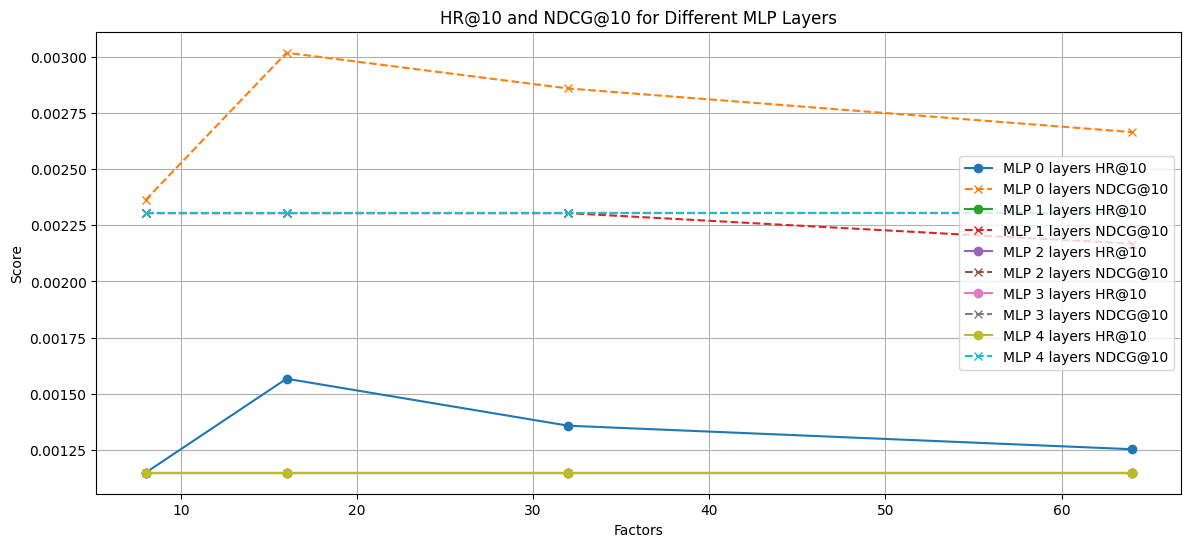

In [11]:
# 训练和评估不同层数的 MLP 模型并存储结果
def train_and_evaluate_mlp_models(factors, epochs, lr):
    results = {"MLP 0 layers": {"HR": [], "NDCG": []},
               "MLP 1 layers": {"HR": [], "NDCG": []},
               "MLP 2 layers": {"HR": [], "NDCG": []},
               "MLP 3 layers": {"HR": [], "NDCG": []},
               "MLP 4 layers": {"HR": [], "NDCG": []},
              }

    for factor in factors:
        mlp_0_layers = MLP(num_users, num_items, [factor])
        mlp_1_layers = MLP(num_users, num_items, [factor*2, factor])
        mlp_2_layers = MLP(num_users, num_items, [factor*4, factor*2, factor])
        mlp_3_layers = MLP(num_users, num_items, [factor*8, factor*4, factor*2, factor])
        mlp_4_layers = MLP(num_users, num_items, [factor*16, factor*8, factor*4, factor*2, factor])
        
        train_model(mlp_0_layers, train_loader, epochs, lr)
        hr0, ndcg0 = evaluate_model(mlp_0_layers, test_loader, test_ratings, k=10)
        results["MLP 0 layers"]["HR"].append(hr0)
        results["MLP 0 layers"]["NDCG"].append(ndcg0)
        #print(f'MLP 0 layers - Factors {factor} - HR@10: {hr0}, NDCG@10: {ndcg0}')

        train_model(mlp_1_layers, train_loader, epochs, lr)
        hr1, ndcg1 = evaluate_model(mlp_1_layers, test_loader, test_ratings, k=10)
        results["MLP 1 layers"]["HR"].append(hr1)
        results["MLP 1 layers"]["NDCG"].append(ndcg1)
        #print(f'MLP 1 layers - Factors {factor} - HR@10: {hr1}, NDCG@10: {ndcg1}')

        train_model(mlp_2_layers, train_loader, epochs, lr)
        hr2, ndcg2 = evaluate_model(mlp_2_layers, test_loader, test_ratings, k=10)
        results["MLP 2 layers"]["HR"].append(hr2)
        results["MLP 2 layers"]["NDCG"].append(ndcg2)
        #print(f'MLP 2 layers - Factors {factor} - HR@10: {hr2}, NDCG@10: {ndcg2}')

        train_model(mlp_3_layers, train_loader, epochs, lr)
        hr3, ndcg3 = evaluate_model(mlp_3_layers, test_loader, test_ratings, k=10)
        results["MLP 3 layers"]["HR"].append(hr3)
        results["MLP 3 layers"]["NDCG"].append(ndcg3)
        #print(f'MLP 3 layers - Factors {factor} - HR@10: {hr3}, NDCG@10: {ndcg3}')
        
        train_model(mlp_4_layers, train_loader, epochs, lr)
        hr4, ndcg4 = evaluate_model(mlp_4_layers, test_loader, test_ratings, k=10)
        results["MLP 4 layers"]["HR"].append(hr4)
        results["MLP 4 layers"]["NDCG"].append(ndcg4)
        #print(f'MLP 4 layers - Factors {factor} - HR@10: {hr4}, NDCG@10: {ndcg4}')

    return results

# 设置训练参数
factors = [8, 16, 32, 64]
epochs = 200
lr = 0.01

# 训练和评估模型
results = train_and_evaluate_mlp_models(factors, epochs, lr)
print(results)

# 可视化结果
plt.figure(figsize=(14, 6))

for model in results.keys():
    plt.plot(factors, results[model]["HR"], marker='o', label=f'{model} HR@10')
    plt.plot(factors, results[model]["NDCG"], marker='x', linestyle='--', label=f'{model} NDCG@10')

plt.xlabel('Factors')
plt.ylabel('Score')
plt.title('HR@10 and NDCG@10 for Different MLP Layers')
plt.legend()
plt.grid(True)
plt.show()

          HR@10                                                      \
   MLP 0 layers MLP 1 layers MLP 2 layers MLP 3 layers MLP 4 layers   
8      0.001150      0.00115      0.00115      0.00115      0.00115   
16     0.001568      0.00115      0.00115      0.00115      0.00115   
32     0.001359      0.00115      0.00115      0.00115      0.00115   
64     0.001254      0.00115      0.00115      0.00115      0.00115   

        NDCG@10                                                      
   MLP 0 layers MLP 1 layers MLP 2 layers MLP 3 layers MLP 4 layers  
8      0.002362     0.002304     0.002304     0.002304     0.002304  
16     0.003017     0.002304     0.002304     0.002304     0.002304  
32     0.002858     0.002304     0.002304     0.002304     0.002304  
64     0.002664     0.002168     0.002304     0.002304     0.002304  


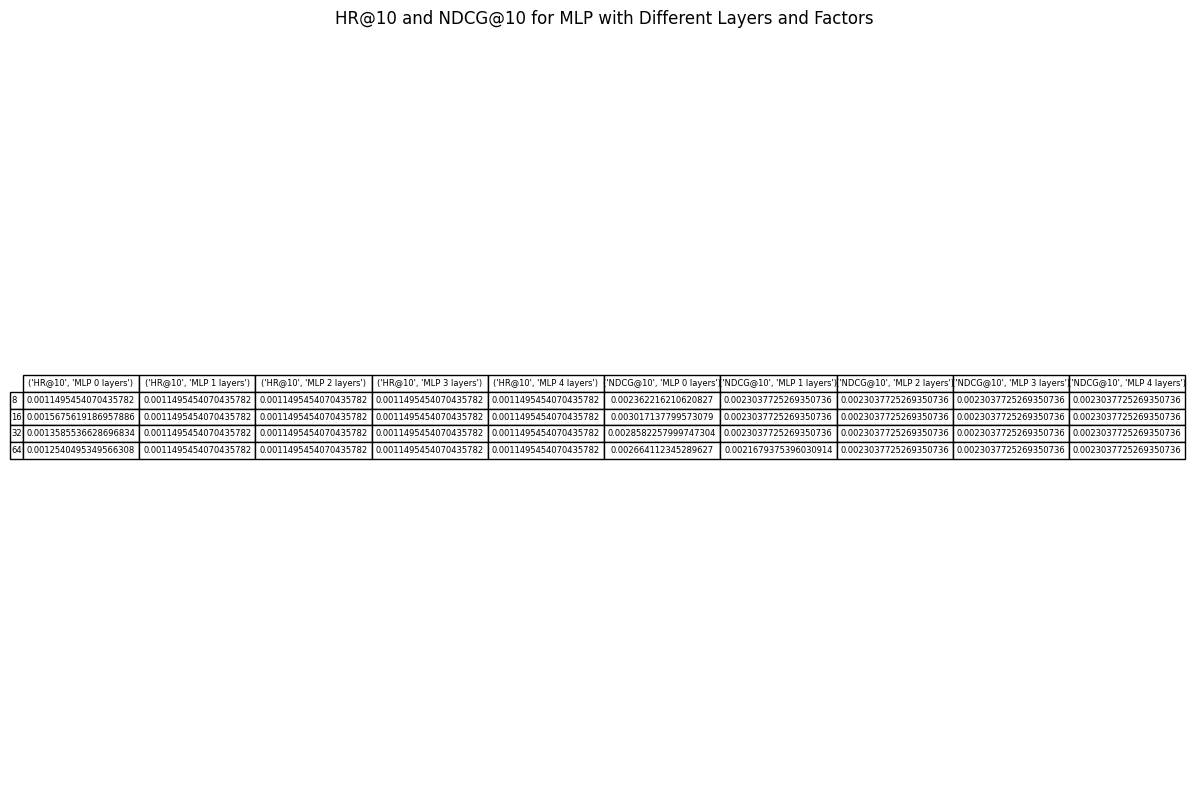

In [5]:
import pandas as pd

# 数据
results = {
    'MLP 0 layers': {'HR': [0.0011495454070435782, 0.0015675619186957886, 0.0013585536628696834, 0.0012540495349566308], 
                     'NDCG': [0.002362216210620827, 0.003017137799573079, 0.0028582257999747304, 0.002664112345289627]},
    'MLP 1 layers': {'HR': [0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782], 
                     'NDCG': [0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736, 0.0021679375396030914]},
    'MLP 2 layers': {'HR': [0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782], 
                     'NDCG': [0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736]},
    'MLP 3 layers': {'HR': [0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782], 
                     'NDCG': [0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736]},
    'MLP 4 layers': {'HR': [0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782, 0.0011495454070435782], 
                     'NDCG': [0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736, 0.0023037725269350736]}
}

# 将数据转换为DataFrame
factors = [8, 16, 32, 64]
df_hr = pd.DataFrame({key: value['HR'] for key, value in results.items()}, index=factors)
df_ndcg = pd.DataFrame({key: value['NDCG'] for key, value in results.items()}, index=factors)

# 创建表格
table = pd.concat([df_hr, df_ndcg], keys=['HR@10', 'NDCG@10'], axis=1)
print(table)

# 保存为表格图片
import matplotlib.pyplot as plt
import matplotlib.table as tbl

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('tight')
ax.axis('off')
table_plot = tbl.table(ax, cellText=table.values, colLabels=table.columns, rowLabels=table.index, loc='center', cellLoc='center')
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(6)
plt.title("HR@10 and NDCG@10 for MLP with Different Layers and Factors")
plt.show()
